In [206]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve,roc_auc_score
from statsmodels.discrete import discrete_model as sm
from statsmodels.tools.tools import add_constant
import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
# look at hinge loss
# put datasets and notebooks on Github

# Journey
- Binomial Log reg derivation (from lin to odds ratio to sigmoid)
- Run through with default set
- look at summary
- Consider different evaluation metrics (which metric more suitable when)


- Multinomial log derivation (swap softmax for sigmoid)
- Cross entropy loss (why we use it widely?)
- Run through with olive dataset
- OVO VS OVR VS MULTINOMIAL


In [208]:
# Binary dataset
data_default = pd.read_excel("Default.xlsx")

In [209]:
# Lets keep it to 2 variables only

# convert student column to categorical

data_default["default"] = data_default["default"].replace("No",0)
data_default["default"] = data_default["default"].replace("Yes",1)

In [210]:
# Quite an imbalanced Dataset
data_default["default"].value_counts()

0    9667
1     333
Name: default, dtype: int64

In [211]:
# split dataset into x and y

y_default = data_default['default']
x_default = data_default.drop(["default","student"],axis =1)

# split into training and test
from sklearn.model_selection import train_test_split
train_x_def,test_x_def,train_y_def,test_y_def = train_test_split(x_default,y_default,test_size = 0.2,random_state=42)

## Logistic Regerssion (under-the-hood)

In [212]:
class LogisticRegression_uday:
    def __init__(self, lr=0.01, num_iter=100000, fit_intercept=True, verbose=False):
        self.lr = lr
        self.num_iter = num_iter
        self.fit_intercept = fit_intercept
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
    
    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))
    def __loss(self, h, y):
        return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()
    
    def fit(self, X, y):
        if self.fit_intercept:
            X = self.__add_intercept(X)
        
        # weights initialization
        self.theta = np.zeros(X.shape[1])
        
        for i in range(self.num_iter):
            z = np.dot(X, self.theta)
            h = self.__sigmoid(z)
            gradient = np.dot(X.T, (h - y)) / y.size
            self.theta -= self.lr * gradient
            
    def predict_prob(self, X):
        if self.fit_intercept:
            X = self.__add_intercept(X)
    
        return self.__sigmoid(np.dot(X, self.theta))
    
    def predict(self, X, threshold):
        return self.predict_prob(X) >= threshold

In [213]:
#model = LogisticRegression_uday(lr=0.1, num_iter=300000)

# converting to NumPy arrays
X = np.asarray(train_x_def)
Y = np.asarray(train_y_def)

from sklearn.preprocessing import StandardScaler
st = StandardScaler()
X = st.fit_transform(X)

In [214]:
#preds = model.predict(X,0.5)


In [215]:
#y = np.bincount(preds)
#ii = np.nonzero(y)[0]
#list(zip(ii,y[ii]) )

## Lets use Sklearn for now

## Fit a Binomial Logistic Function

In [216]:
# Initiate model, fit and predict
log_model = LogisticRegression()
log_model.fit(train_x_def,train_y_def) # log_model(y_train,x_Train).fit()
prediction_sk = log_model.predict(train_x_def) # predicted classes
prediction_probs = log_model.predict_proba(train_x_def) # probability values

In [217]:
log_model.coef_
#print(log_model.coef_.shape)

array([[ 0.0004439 , -0.00012839]])

In [283]:

h = .02  # step size in the mesh

logreg = LogisticRegression(C=1)

# we create an instance of Neighbours Classifier and fit the data.
logreg.fit(X, Y)






LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [284]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])


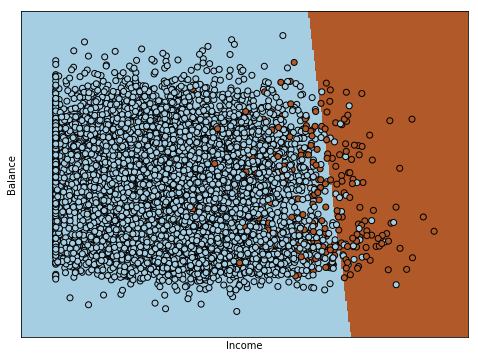

In [289]:
# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(8, 6))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)
plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel('Income')
plt.ylabel('Balance')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())

plt.show()

## Evaluation

In [290]:
confusion_matrix(train_y_def,prediction_sk)

array([[7731,    5],
       [ 264,    0]])

In [291]:
print((classification_report(train_y_def, prediction_sk)))

             precision    recall  f1-score   support

          0       0.97      1.00      0.98      7736
          1       0.00      0.00      0.00       264

avg / total       0.94      0.97      0.95      8000



### Which metric is most relevant in this exercise?

- Precision tells us more about our positive predictions. Out of all positive predictions we made, how many were on target, how many were not. 
- Recall tell us more about relevancy. Out of all actual "No" defaulters, all our predictions were relevant in that all actual "No" defaulters were correctly predicted.
- F1 is the harmonic average of precision and recall (F1 = 2 * (PRE * REC) / (PRE + REC). While this is usually a good metric for inbalanced datasets, here the avg F1 reflects the model is better than it actually is. 
- The last line 'avg'  gives a weighted average of precision, recall and f1-score where the weights are the support values. So for precision the avg is (0.96x1930 + 0.x70)/2000 = 0.93


In this imbalanced dataset, our greatest concern is catching the defaulters, so I would focus on the precision and recall scores for the 'Yes'/1 class.




## A visual Metric: ROC curve and the area underneath it

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity or recall. 

In [223]:
fpr, tpr, threshold = roc_curve(train_y_def, prediction_probs[:,1]) 
fpr_no, tpr_no, threshold_no = roc_curve(train_y_def, prediction_probs[:,0]) 

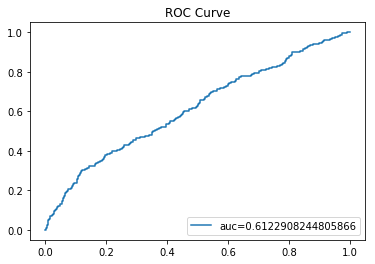

In [224]:
auc = roc_auc_score(train_y_def, prediction_probs[:,1])
auc_no = roc_auc_score(train_y_def, prediction_probs[:,0])

plt.plot(fpr,tpr,label="auc="+str(auc))
plt.title("ROC Curve")
plt.legend(loc=4)
plt.show()

## Aside: Adjusting Proability Thresholds

In [225]:
prediction_probs[:,1]

array([0.01933326, 0.02528055, 0.00835516, ..., 0.04132987, 0.06697929,
       0.0022546 ])

In [226]:
threshold_10 = []
for i in prediction_probs[:,1]:
    if i>= 0.1:
        threshold_10.append(1)
    else:
        threshold_10.append(0)

In [227]:
confusion_matrix(train_y_def,threshold_10)

array([[6047, 1689],
       [ 160,  104]])

In [228]:
print((classification_report(train_y_def, threshold_10)))

             precision    recall  f1-score   support

          0       0.97      0.78      0.87      7736
          1       0.06      0.39      0.10       264

avg / total       0.94      0.77      0.84      8000



In [229]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(train_y_def, threshold_10)

0.046249423571514736

## Aside: Balanced Sampling

In [230]:
from sklearn.linear_model import LogisticRegressionCV

log_cv = LogisticRegressionCV(cv=12,class_weight = {1:15})
log_cv.fit(train_x_def,train_y_def) # log_model(y_train,x_Train).fit()
prediction_cv = log_cv.predict(train_x_def) # predicted classes
prediction_cv_probs = log_cv.predict_proba(train_x_def) # probability values

In [231]:
print((classification_report(train_y_def, prediction_cv)))

             precision    recall  f1-score   support

          0       0.99      0.92      0.95      7736
          1       0.26      0.81      0.39       264

avg / total       0.97      0.92      0.94      8000



In [232]:
confusion_matrix(train_y_def,prediction_cv)

array([[7112,  624],
       [  49,  215]])

In [233]:
fpr_cv, tpr_cv, threshold_cv = roc_curve(train_y_def, prediction_cv_probs[:,1]) 
#fpr_no, tpr_no, threshold_no = roc_curve(train_y_def, prediction_probs[:,0]) 

### Creating a more appropriate threshold at 10%

In [234]:
threshold_10_cv = []
for i in prediction_cv_probs[:,1]:
    if i>= 0.1:
        threshold_10_cv.append(1)
    else:
        threshold_10_cv.append(0)

In [235]:
print((classification_report(train_y_def, threshold_10_cv)))

             precision    recall  f1-score   support

          0       1.00      0.70      0.83      7736
          1       0.10      0.97      0.18       264

avg / total       0.97      0.71      0.80      8000



In [236]:
confusion_matrix(train_y_def,threshold_10_cv)

array([[5446, 2290],
       [   8,  256]])

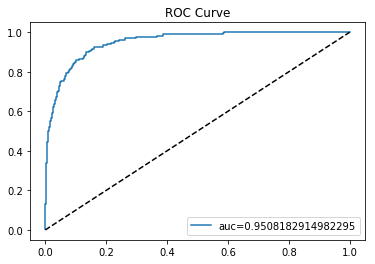

In [238]:
auc_cv = roc_auc_score(train_y_def, prediction_cv_probs[:,1])
#auc_no_cv = roc_auc_score(train_y_def, prediction_cv_probs[:,0])

plt.plot(fpr_cv,tpr_cv,label="auc="+str(auc_cv))

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve")
plt.legend(loc=4)
plt.show()

## SMOTE

In [239]:
from imblearn.over_sampling import SMOTE



In [240]:

sm = SMOTE(ratio='auto', kind='regular')
X_resampled , y_resampled = sm.fit_sample(train_x_def, train_y_def)

In [241]:
#fit model with new data

log_cv.fit(X_resampled,y_resampled)
prediction_smote = log_cv.predict(X_resampled) # predicted classes
prediction_smote_probs = log_cv.predict_proba(X_resampled) # probability values


In [242]:
print((classification_report(y_resampled, prediction_smote)))

             precision    recall  f1-score   support

          0       1.00      0.42      0.59      7736
          1       0.63      1.00      0.77      7736

avg / total       0.81      0.71      0.68     15472



In [243]:
confusion_matrix(y_resampled,prediction_smote)

array([[3238, 4498],
       [  13, 7723]])

## Trial on Test Data

In [244]:
prediction_cv_test = log_cv.predict(test_x_def) # predicted classes
prediction_cv_probs_test = log_cv.predict_proba(test_x_def) # probability values

In [245]:
print((classification_report(test_y_def, prediction_cv_test)))

             precision    recall  f1-score   support

          0       1.00      0.40      0.57      1931
          1       0.06      1.00      0.11        69

avg / total       0.97      0.42      0.55      2000



In [246]:
confusion_matrix(test_y_def,prediction_cv_test)

array([[ 768, 1163],
       [   0,   69]])

In [247]:
threshold_10_test = []
for i in prediction_cv_probs_test[:,1]:
    if i>= 0.30:
        threshold_10_test.append(1)
    else:
        threshold_10_test.append(0)

In [248]:
print((classification_report(test_y_def, threshold_10_test)))

             precision    recall  f1-score   support

          0       1.00      0.25      0.40      1931
          1       0.05      1.00      0.09        69

avg / total       0.97      0.28      0.39      2000



In [249]:
confusion_matrix(test_y_def,threshold_10_test)

array([[ 485, 1446],
       [   0,   69]])

## Multi-class setting: Multinomial Regression

In [250]:
# Multilabel
data_oil = pd.read_csv("olive_oil.csv")

In [251]:
# This is the main change in going from Binomial to Multinomial

import numpy as np
 
 
def softmax(inputs):
    """
    Calculate the softmax for the give inputs (array)
    :param inputs:
    :return:
    """
    return np.exp(inputs) / float(sum(np.exp(inputs)))
 
 
softmax_inputs = [2, 3, 5, 6]
print("Softmax Function Output :: {}".format(softmax(softmax_inputs)))


Softmax Function Output :: [0.01275478 0.03467109 0.25618664 0.69638749]


In [252]:
data_oil =  data_oil.drop(["Unnamed: 0","area"],axis = 1)

In [253]:

y_oil = data_oil['region']
x_oil = data_oil.drop(["region"],axis =1)

# standardize as we are engaging in gradient descent and Regularization

x_oil_std= st.fit_transform(x_oil)

# split into training and test
from sklearn.model_selection import train_test_split
train_x_oil,test_x_oil,train_y_oil,test_y_oil = train_test_split(x_oil_std,y_oil,test_size = 0.2,random_state = 42)

In [254]:
### Standardize data
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

#x_oil_std = scaler.fit_transform(x_oil)

In [255]:
# specify multinomial settings
log_multi = LogisticRegression(solver = 'sag',multi_class = 'multinomial',fit_intercept = False)
# by default L2 regularization is set

log_multi.fit(train_x_oil,train_y_oil)
prediction_oil = log_multi.predict(test_x_oil)
prediction_probs_oil = log_multi.predict_proba(test_x_oil)

In [256]:
log_multi.coef_

array([[ 0.69170539,  1.03989274, -0.36744401, -0.51043928, -0.00982408,
         1.74033096, -0.36791034,  3.30427342],
       [-0.86501258, -1.15308333,  0.17478839, -0.44146647,  1.32462362,
        -0.90902875,  0.7608415 , -1.10278427],
       [ 0.17330719,  0.1131906 ,  0.19265562,  0.95190575, -1.31479955,
        -0.83130221, -0.39293116, -2.20148915]])

In [257]:
confusion_matrix(test_y_oil,prediction_oil)

array([[65,  2,  4],
       [ 0, 14,  0],
       [ 0,  0, 30]])

In [258]:
print((classification_report(test_y_oil, prediction_oil)))

             precision    recall  f1-score   support

          1       1.00      0.92      0.96        71
          2       0.88      1.00      0.93        14
          3       0.88      1.00      0.94        30

avg / total       0.95      0.95      0.95       115



## Explicitly computing the Cross-entropy Loss

In [259]:
# -log P(yt|yp) = -(yt log(yp) + (1 - yt) log(1 - yp))

from sklearn.metrics import log_loss

multi_loss = log_loss(y_pred = prediction_probs_oil, y_true = test_y_oil )

In [260]:
multi_loss

0.14292045554657912

In [261]:
# ovo setting 
log_ovr = LogisticRegression()
log_ovr.fit(train_x_oil,train_y_oil)
prediction_oil_ovr = log_multi.predict(test_x_oil)
prediction_probs_oil_ovr = log_multi.predict_proba(test_x_oil)

In [262]:
print((classification_report(test_y_oil, prediction_oil_ovr)))

             precision    recall  f1-score   support

          1       1.00      0.92      0.96        71
          2       0.88      1.00      0.93        14
          3       0.88      1.00      0.94        30

avg / total       0.95      0.95      0.95       115



In [263]:
log_ovr.coef_

array([[ 0.88857175,  1.16111176, -0.14910727, -0.60668187, -0.10009561,
         0.94801903, -0.351341  ,  3.84475413],
       [-1.5585026 , -1.70552421, -0.1642905 , -0.80511715,  2.73766215,
        -0.36660828,  1.35212308, -1.61227013],
       [ 0.40374448, -0.01140604,  0.107687  ,  1.5640411 , -2.26757891,
        -0.30263188, -0.75397954, -2.8756931 ]])

## Discussion: OVA, OVR and Multinomial

1) OVA/OVR : The assumption is that there are K independent logistic regressions, one for each class, i.e., for class i, we learn a logistic (probability) model of the sigmoid form, and each of these K problems is independent of the other K-1 logistic regression problems. So, we learn a 𝛽𝑖 independently for each class i.

2) OVO: Here, we fit a logistic model for each pair of categories. This is definitely a computaitonally more expensinve as the number of pairs grow exponentially with the number of classes.

3) Multinomial: For a class i we have the multinomial logitic model . As you can see immediately, learning 𝛽𝑖 for a particular class i immediately affects our model for other classes j through the joint model. 


In [274]:
# L2 Regularization with GridSearch

from sklearn.model_selection import GridSearchCV
params_dict = {"C": np.logspace(-1, 3, 50)}

# Fit the grid search
search = GridSearchCV(estimator=log_multi, param_grid=params_dict,cv=3,scoring ='neg_log_loss')
search.fit(train_x_oil,train_y_oil)

/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reac

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-01, 1.20679e-01, 1.45635e-01, 1.75751e-01, 2.12095e-01,
       2.55955e-01, 3.08884e-01, 3.72759e-01, 4.49843e-01, 5.42868e-01,
       6.55129e-01, 7.90604e-01, 9.54095e-01, 1.15140e+00, 1.38950e+00,
       1.67683e+00, 2.02359e+00, 2.44205e+00, 2.94705e+00, 3.55648e... 3.23746e+02, 3.90694e+02,
       4.71487e+02, 5.68987e+02, 6.86649e+02, 8.28643e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [275]:
print("Best parameter values:", search.best_params_)
print("CV Score with best parameter values:", search.best_score_)

Best parameter values: {'C': 3.5564803062231287}
CV Score with best parameter values: -0.08747127205254084


In [276]:
# Regularization: L1

In [277]:
log_l1 = LogisticRegression(penalty = 'l1',solver = 'saga',multi_class = 'multinomial',fit_intercept = False)
log_l1.fit(train_x_oil,train_y_oil)

params_dict = {"C": np.logspace(-1, 3, 50)}

# Fit the grid search
search_l1 = GridSearchCV(estimator=log_l1, param_grid=params_dict,cv=5,scoring ='neg_log_loss')
search_l1.fit(train_x_oil,train_y_oil)
#prediction_oil_ovr_l1 = log_l1.predict(test_x_oil)
#prediction_probs_oil_ovr_l1 = log_l1.predict_proba(test_x_oil)

/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/uday/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reac

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=False,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l1', random_state=None, solver='saga',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': array([1.00000e-01, 1.20679e-01, 1.45635e-01, 1.75751e-01, 2.12095e-01,
       2.55955e-01, 3.08884e-01, 3.72759e-01, 4.49843e-01, 5.42868e-01,
       6.55129e-01, 7.90604e-01, 9.54095e-01, 1.15140e+00, 1.38950e+00,
       1.67683e+00, 2.02359e+00, 2.44205e+00, 2.94705e+00, 3.55648e... 3.23746e+02, 3.90694e+02,
       4.71487e+02, 5.68987e+02, 6.86649e+02, 8.28643e+02, 1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_log_loss', verbose=0)

In [279]:
print("Best parameter values:", search_l1.best_params_)
print("CV Score with best parameter values:", search_l1.best_score_)

Best parameter values: {'C': 1.3894954943731375}
CV Score with best parameter values: -0.08498294803334472


In [43]:
log_l1.coef_

array([[ 2.3063226 ,  1.15839306, -1.75413018,  0.        ,  0.        ,
         0.98629009,  0.        ,  8.40045182],
       [-1.05350456, -1.33640018,  0.        ,  0.        ,  2.70884284,
         0.        ,  1.38385815,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -0.90949576,
         0.        ,  0.        , -1.74268032]])

In [44]:
print((classification_report(test_y_oil, prediction_oil_ovr_l1)))

             precision    recall  f1-score   support

          1       1.00      0.95      0.97        59
          2       0.92      1.00      0.96        23
          3       0.97      1.00      0.99        33

avg / total       0.98      0.97      0.97       115



##  Discussion 
Both L1 and L2 regularization have Bayesian interpretations as constraints on the prior of how weights should look. L1 regularization can be viewed as a Laplace prior on the weights. L2 regularization corresponds to assuming that weights are distributed according to a gaussian distribution with mean μ = 0